In [3]:
import time
import requests
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape, mse
from utilsforecast.evaluation import evaluate

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, LSTM

from utilsforecast.plotting import plot_series
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-u0uuMKxJQLH7NljBpZRjckwKuENxptz6beRKSaVPvjPheR4P5H9J3Ju9rK47rGoN4qeUqlxgoqICfJ1O'
)

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])


df.groupby('unique_id').head(2)

,unique_id,ds,y
0,AP-AP,2023-10-01 04:00:00+00:00,4042.513
1,AP-AP,2023-10-01 05:00:00+00:00,3850.067
8784,DOM-DOM,2023-10-01 04:00:00+00:00,10732.435
8785,DOM-DOM,2023-10-01 05:00:00+00:00,10314.211
17568,JC-JC,2023-10-01 04:00:00+00:00,1825.101
17569,JC-JC,2023-10-01 05:00:00+00:00,1729.590
26352,PN-PN,2023-10-01 04:00:00+00:00,1454.666
26353,PN-PN,2023-10-01 05:00:00+00:00,1416.688
35136,RTO-RTO,2023-10-01 04:00:00+00:00,69139.393
35137,RTO-RTO,2023-10-01 05:00:00+00:00,66207.416


In [4]:
def generate_inputs(df, days=73):

    test_df = df.groupby('unique_id').tail(24 * days)
    train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-1 * (24 * days)]).reset_index(drop=True)


    #create list of 73 days true values for each unique_id
    Y_df = [
    test_df.groupby('unique_id', group_keys=False).apply(lambda group: group.iloc[i:i+24]).reset_index(drop=True)
    for i in range(0, 24 * days, 24)
    ]

    p = 1

    #create paired inputs
    inputs_df = [Y_df[i] for i in range(len(Y_df) - p)]

    inputs_df.insert(0, train_df.groupby('unique_id', group_keys=False).apply(lambda group: group.iloc[-24:]))


    return Y_df, inputs_df, train_df, test_df


In [ ]:
Y_df, inputs_df, train_df, test_df = generate_inputs(df)

#Models

In [ ]:
models = [NHITS(
                h=24,
                input_size=24,
                scaler_type='robust',
                batch_size=16,
                valid_batch_size=8,
                max_steps=3000
          ),

          LSTM(
              h=24,
              input_size=24,
              scaler_type='robust',
              encoder_n_layers=1,
              encoder_hidden_size=64,
              context_size=128,
              decoder_hidden_size=128,
              decoder_layers=5,
              learning_rate=1e-4,
              max_steps=3000
          )
]

nf = NeuralForecast(models=models, freq='h')
nf.fit(df=train_df)

In [7]:
nf.save(
    path='./checkpoint/models/',
    model_index=None,
    overwrite=True,
    save_dataset=True
)

In [8]:
def funcs_test(inputs_df, Y_df):

  preds = [nf.predict(inputs_df[i]) for i in range(len(Y_df))]
  y_preds_df = [pd.merge(Y_df[i], preds[i], 'left', ['unique_id', 'ds']) for i in range(len(Y_df))]

  evals = []

  for i in range(len(y_preds_df)):
      evaluation = evaluate(
                  y_preds_df[i],
                  metrics=[mse, mae, smape],
                  models=['NHITS', 'LSTM'],
                  target_col='y',
                  id_col='unique_id'
                )

      evals.append(evaluation)

  return evals, preds, y_preds_df

In [ ]:
evaluations, preds, y_preds_df = funcs_test(inputs_df, Y_df)

In [10]:
preds_concat= pd.concat(preds, ignore_index=True)
Y_df_concat = pd.concat(Y_df, ignore_index=True)

#TimeGPT

In [11]:

def TimegptForecast():
  full_forecast = []
  training_data = train_df.copy()

  for i in range(0, 24 * 73, 24):

      fcst_df = nixtla_client.forecast(
          df=training_data,
          h=24,
          finetune_steps=10,
          finetune_loss='mae',
          model='timegpt-1',
          time_col='ds',
          target_col='y',
          id_col='unique_id'
      )

      #1 day from train set + 1 day from test -> 2 days from test -> next 2 days from test
      training_data = pd.concat([training_data, test_df.groupby('unique_id', group_keys=False).apply(lambda group: group.iloc[i:i+24])], ignore_index=True)

      full_forecast.append(fcst_df)

  return full_forecast


In [ ]:
forecasts = TimegptForecast()

In [13]:
forecasts = pd.concat(forecasts, ignore_index=True)

In [14]:
all_res = pd.merge(preds_concat, forecasts, 'left', ['unique_id', 'ds'])

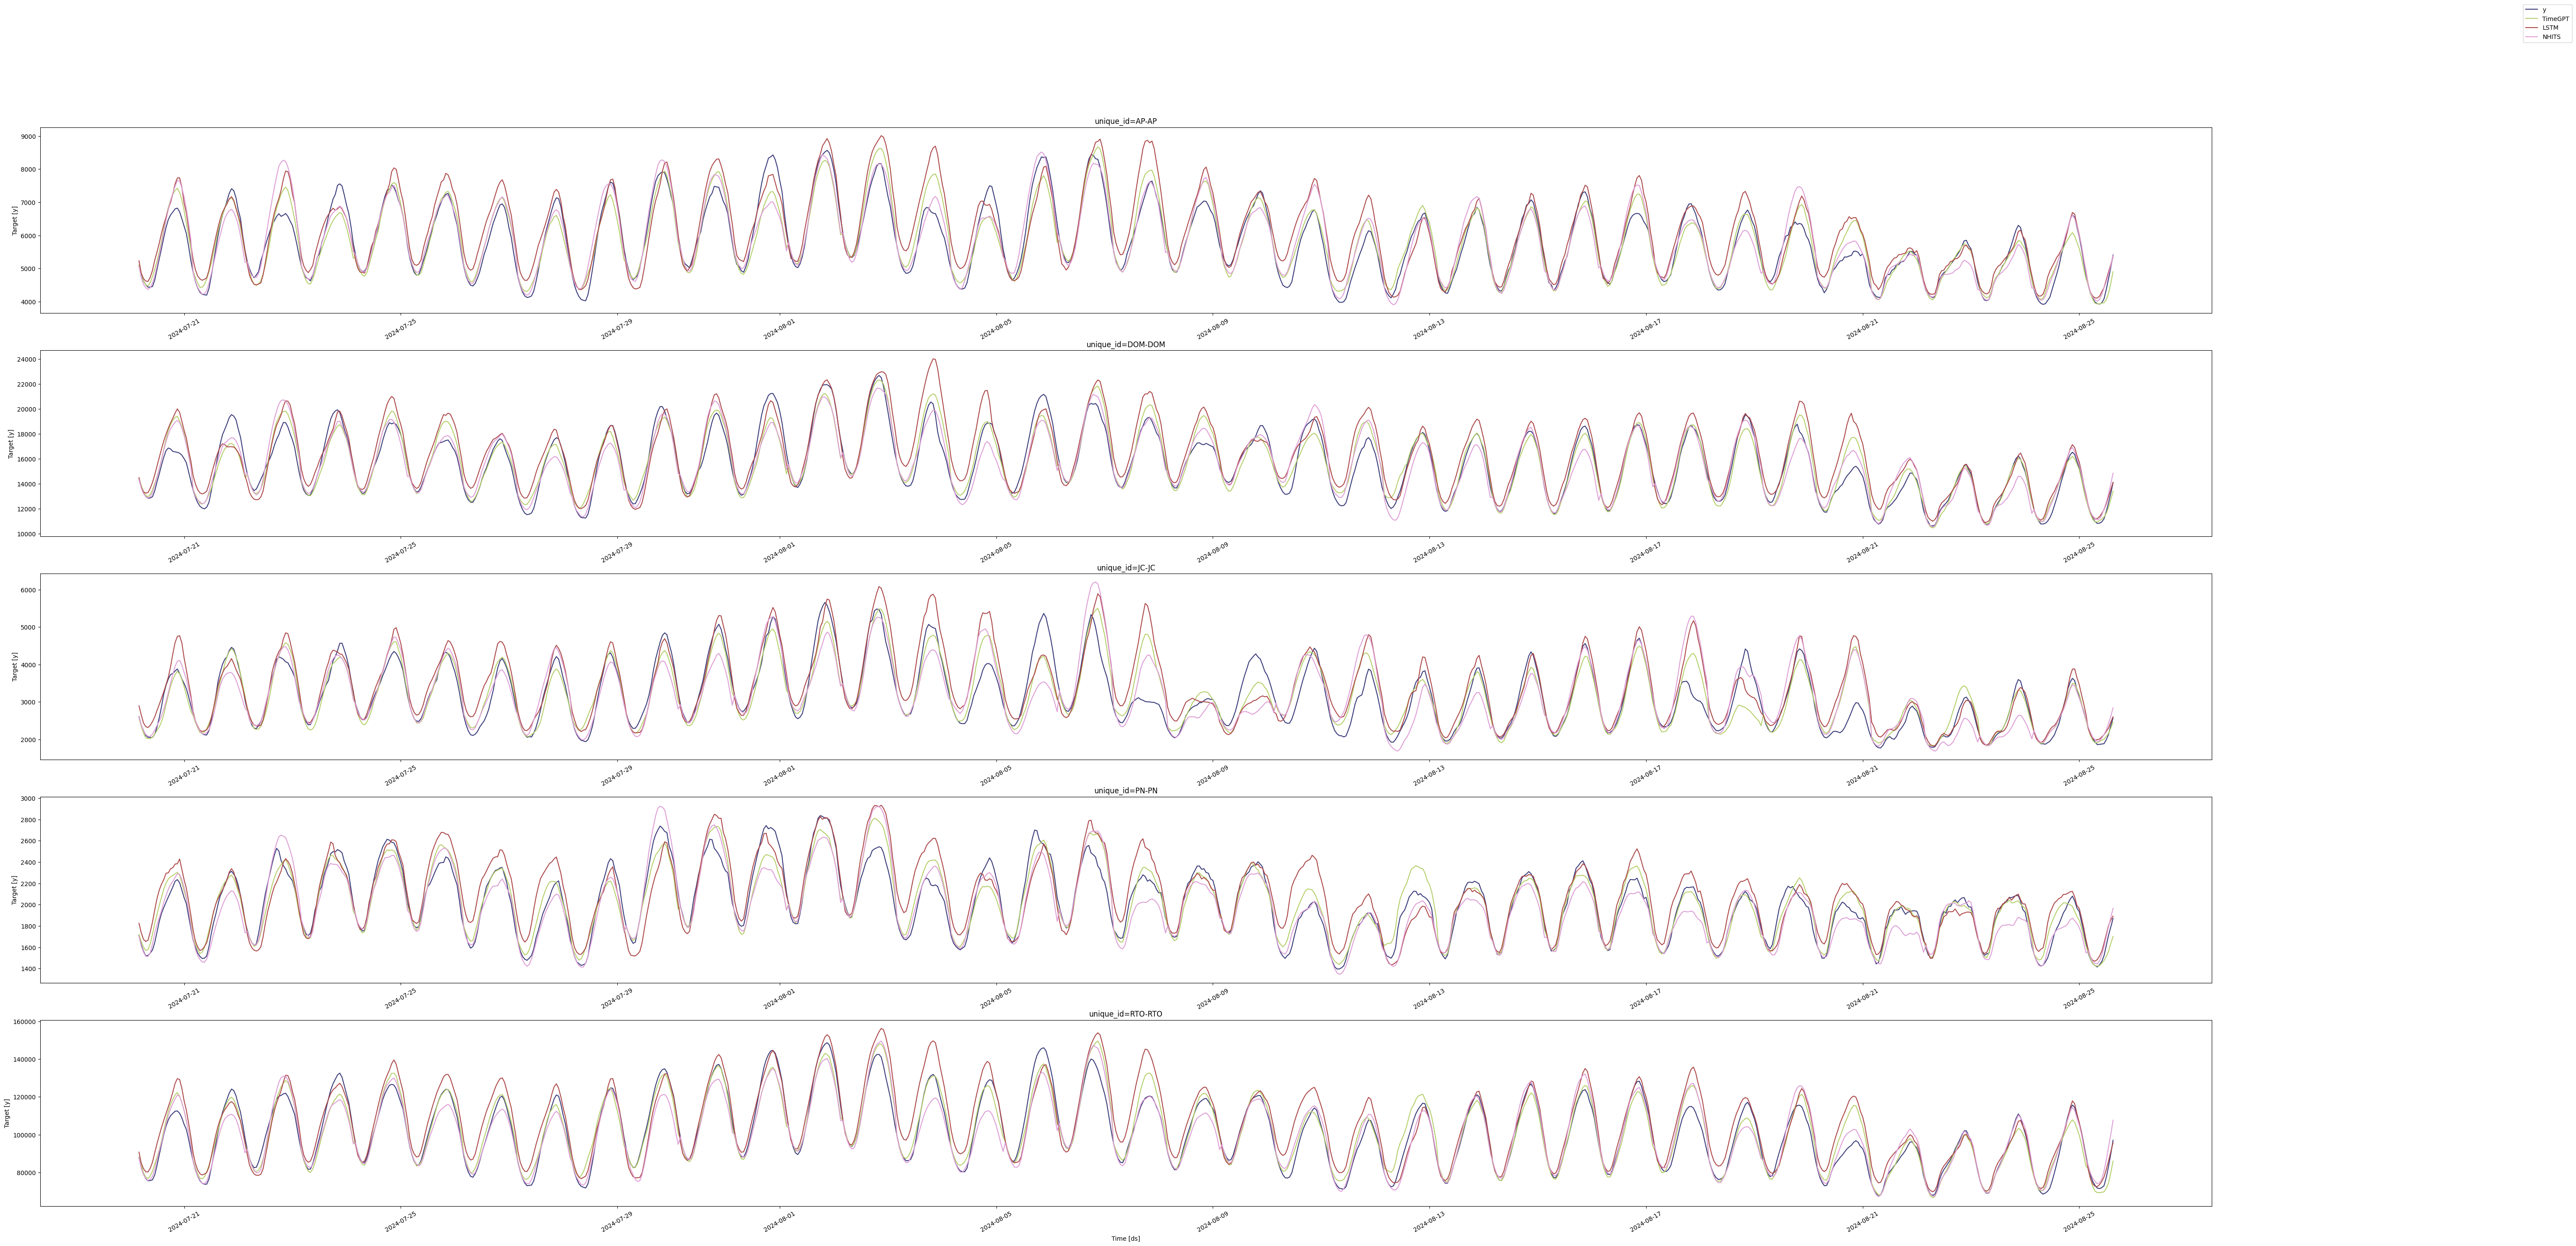

In [15]:

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(64, 32))


nixtla_client.plot(Y_df_concat.groupby('unique_id').head(876),
                   all_res.groupby('unique_id').head(876),
                   models=['TimeGPT', 'LSTM', 'NHITS'], time_col='ds',
                   target_col='y', ax=axes)

In [16]:
Y_df_concat = pd.concat(Y_df, ignore_index=True)

In [17]:
eval_df = pd.merge(Y_df_concat, all_res, 'left', ['unique_id', 'ds'])
eval_df.to_csv('nixtla_preds.csv', index=False)

In [18]:
evaluation = evaluate(
    eval_df,
    metrics=[mse, mae, smape],
    models=['NHITS', 'LSTM', 'TimeGPT'],
    target_col='y',
    id_col='unique_id'
)


In [19]:
pd.set_option('display.float_format', '{:.6f}'.format)
evaluation.sort_values(['unique_id', 'metric']).groupby('unique_id', group_keys=False).head()

,unique_id,metric,NHITS,LSTM,TimeGPT
5,AP-AP,mae,265.232759,382.074835,246.132677
0,AP-AP,mse,157771.784792,254572.706277,136064.465658
10,AP-AP,smape,0.022741,0.033176,0.021203
6,DOM-DOM,mae,642.374767,861.898587,568.723548
1,DOM-DOM,mse,824268.594891,1375080.350861,663227.729666
11,DOM-DOM,smape,0.020752,0.027838,0.018338
7,JC-JC,mae,280.927306,299.278668,220.633580
2,JC-JC,mse,193375.764707,206024.946628,119938.012495
12,JC-JC,smape,0.044837,0.048681,0.036185
8,PN-PN,mae,86.816007,124.665771,73.375491


In [20]:
nhits_mean = evaluation.groupby('metric')['NHITS'].mean().apply(lambda x: f"{x:.6f}")
timegpt_mean = evaluation.groupby('metric')['TimeGPT'].mean().apply(lambda x: f"{x:.6f}")
lstm_mean = evaluation.groupby('metric')['LSTM'].mean().apply(lambda x: f"{x:.6f}")

formatted_df = pd.DataFrame({
    "NHITS": nhits_mean,
    "LSTM": lstm_mean,
    "TimeGPT": timegpt_mean,
})

formatted_df

,NHITS,LSTM,TimeGPT
metric,,,
mae,1024.147197,1561.046418,964.681045
mse,5969417.929247,13446110.401659,6192463.963497
smape,0.025818,0.034447,0.022537


In [21]:
all_res.to_csv("nixtla_preds.csv")